<center><h1>Panchal_Apoorva_HW5</h1></center>
<br>
<br>

Name: Apoorva Panchal
<br>
Github Username: ApoorvaPanchal
<br>
USC ID: 8685016290

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from urllib.request import urlretrieve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LassoCV, Ridge, LinearRegression
from skmultilearn.problem_transform import LabelPowerset
from sklearn.discriminant_analysis import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from tabulate import tabulate
from xgboost import XGBRegressor

### (a) Obtain Data

Get the Accute Inamations Data Set

In [3]:
url = 'https://archive.ics.uci.edu/static/public/184/acute+inflammations.zip'
filename = '../data/acute_inflammations.zip'
urlretrieve(url, filename)

('../data/acute_inflammations.zip', <http.client.HTTPMessage at 0x1526a8250>)

In [4]:
zip = zipfile.ZipFile('../data/acute_inflammations.zip', 'r').extractall('../data/')
cols = ['Temperature', 'Nausea', 'LumbarPain', 'UrinePushing', 'MicturitionPains', 'Burning', 'Inflammation', 'Nephritis']
features = ['Temperature', 'Nausea', 'LumbarPain', 'UrinePushing', 'MicturitionPains', 'Burning']
target = ['Inflammation', 'Nephritis']
main_df = pd.read_csv('../data/diagnosis.data', sep='\s+', encoding='UTF_16', names=cols,header=None, decimal=',')


lb = LabelEncoder() 
for i in cols:
    if(i=='Temperature'):
        continue
    main_df[i] = lb.fit_transform(main_df[i])

# print(main_df)


In [5]:
lb_powerset = LabelPowerset()
main_df['class'] = lb_powerset.transform(main_df[target])
print(main_df)

     Temperature  Nausea  LumbarPain  UrinePushing  MicturitionPains  Burning  \
0           35.5       0           1             0                 0        0   
1           35.9       0           0             1                 1        1   
2           35.9       0           1             0                 0        0   
3           36.0       0           0             1                 1        1   
4           36.0       0           1             0                 0        0   
..           ...     ...         ...           ...               ...      ...   
115         41.4       0           1             1                 0        1   
116         41.5       0           0             0                 0        0   
117         41.5       1           1             0                 1        0   
118         41.5       0           1             1                 0        1   
119         41.5       0           1             1                 0        1   

     Inflammation  Nephriti

In [6]:
# classifier = LabelPowerset(DecisionTreeClassifier(random_state=1234))
classifier = DecisionTreeClassifier(random_state=1234)
classifier.fit(main_df[features], main_df['class'])

DecisionTreeClassifier(random_state=1234)

### Class Legend :   
#### Inflammation = 0 & Nephritis = 0 : 0  
#### Inflammation = 1 & Nephritis = 0 : 1   
#### Inflammation = 0 & Nephritis = 1 : 2   
#### Inflammation = 1 & Nephritis = 1 : 3  

### (b) Build a decision tree

|--- feature_2 <= 0.50
|   |--- feature_0 <= 38.95
|   |   |--- class: 1
|   |--- feature_0 >  38.95
|   |   |--- class: 0
|--- feature_2 >  0.50
|   |--- feature_0 <= 37.95
|   |   |--- class: 0
|   |--- feature_0 >  37.95
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 2
|   |   |--- feature_1 >  0.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 3



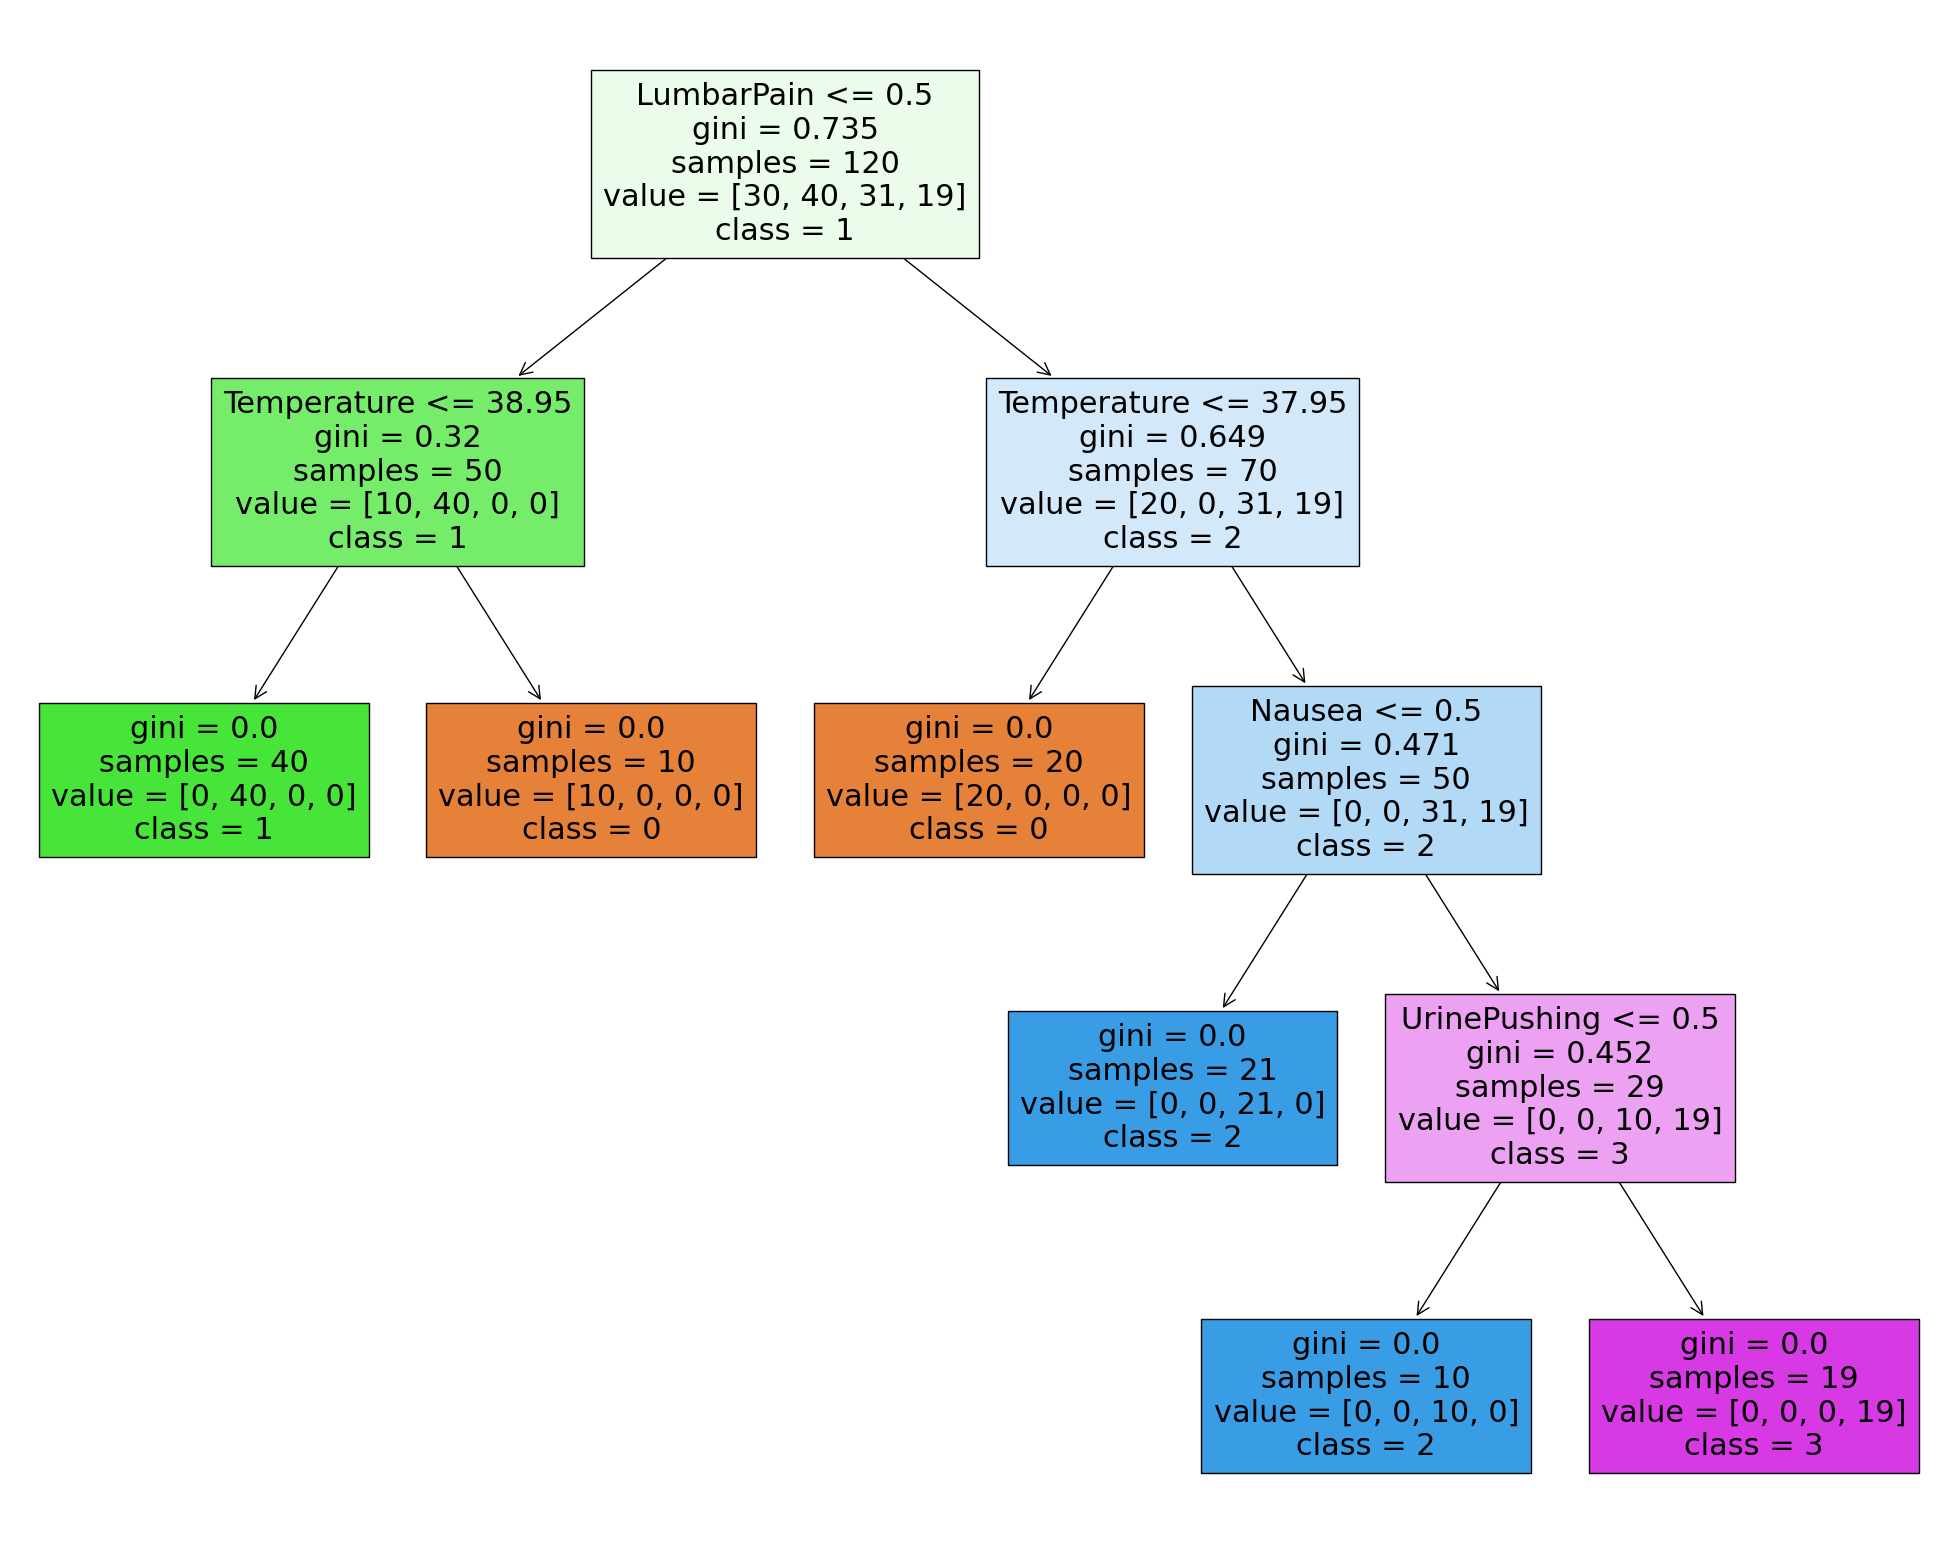

In [7]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classifier, 
                   feature_names=features,  
                   class_names=['0','1', '2', '3'],
                   filled=True)
print(tree.export_text(classifier))


In [8]:
lb_powerset.unique_combinations_

{'': 0, '0': 1, '1': 2, '0,1': 3}

### (c) Convert the decision rules

In [9]:
# Code taken from https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html
def tree_to_pseudo(tree, feature_names):
	"""
	Outputs a decision tree model as if/then pseudocode
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as pseudocode
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	left = tree.tree_.children_left
	right = tree.tree_.children_right
	threshold = tree.tree_.threshold
	features = [feature_names[i] for i in tree.tree_.feature]
	value = tree.tree_.value

	def recurse(left, right, threshold, features, node, depth=0):
		indent = "  " * depth
		if (threshold[node] != -2):
			print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
			if left[node] != -1:
				recurse (left, right, threshold, features, left[node], depth+1)
				print(indent,"} else {")
				if right[node] != -1:
					recurse (left, right, threshold, features, right[node], depth+1)
				print(indent,"}")
		else:
			print(indent,"then return " + str(value[node]))

	recurse(left, right, threshold, features, 0)


In [10]:
tree_to_pseudo(classifier, features)

 if ( LumbarPain <= 0.5 ) {
   if ( Temperature <= 38.95000076293945 ) {
     then return [[ 0. 40.  0.  0.]]
   } else {
     then return [[10.  0.  0.  0.]]
   }
 } else {
   if ( Temperature <= 37.95000076293945 ) {
     then return [[20.  0.  0.  0.]]
   } else {
     if ( Nausea <= 0.5 ) {
       then return [[ 0.  0. 21.  0.]]
     } else {
       if ( UrinePushing <= 0.5 ) {
         then return [[ 0.  0. 10.  0.]]
       } else {
         then return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


### (d) Cost-complexity pruning to find a minimal decision tree

In [11]:
# Code taken from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

path = classifier.cost_complexity_pruning_path(main_df[features], main_df['class'])
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=ccp_alpha)
    clf.fit(main_df[features], main_df['class'])
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.22291666666666676


In [12]:
accuracy_scores = [clf.score(main_df[features], main_df['class']) for clf in clfs]

print(ccp_alphas)
print(impurities)
print(accuracy_scores)

[0.         0.09816667 0.13333333 0.182      0.22291667]
[0.         0.19633333 0.32966667 0.51166667 0.73458333]
[1.0, 0.8416666666666667, 0.7583333333333333, 0.5916666666666667, 0.3333333333333333]


#### Since the last tree with ccp_alpha 0.22291666666666676 has only one node, it is a trivial tree and does not provide us with much information  
#### As observed above, the highest accuracy score (1) is obtained when the alpha is 0. If we want a further pruned tree, we can select alpha as 0.09816667. The rules and decision tree for which is shown below. For the highest accuracy score, the decision tree remains the same

|--- feature_2 <= 0.50
|   |--- feature_0 <= 38.95
|   |   |--- class: 1
|   |--- feature_0 >  38.95
|   |   |--- class: 0
|--- feature_2 >  0.50
|   |--- feature_0 <= 37.95
|   |   |--- class: 0
|   |--- feature_0 >  37.95
|   |   |--- class: 2

 if ( LumbarPain <= 0.5 ) {
   if ( Temperature <= 38.95000076293945 ) {
     then return [[ 0. 40.  0.  0.]]
   } else {
     then return [[10.  0.  0.  0.]]
   }
 } else {
   if ( Temperature <= 37.95000076293945 ) {
     then return [[20.  0.  0.  0.]]
   } else {
     then return [[ 0.  0. 31. 19.]]
   }
 }


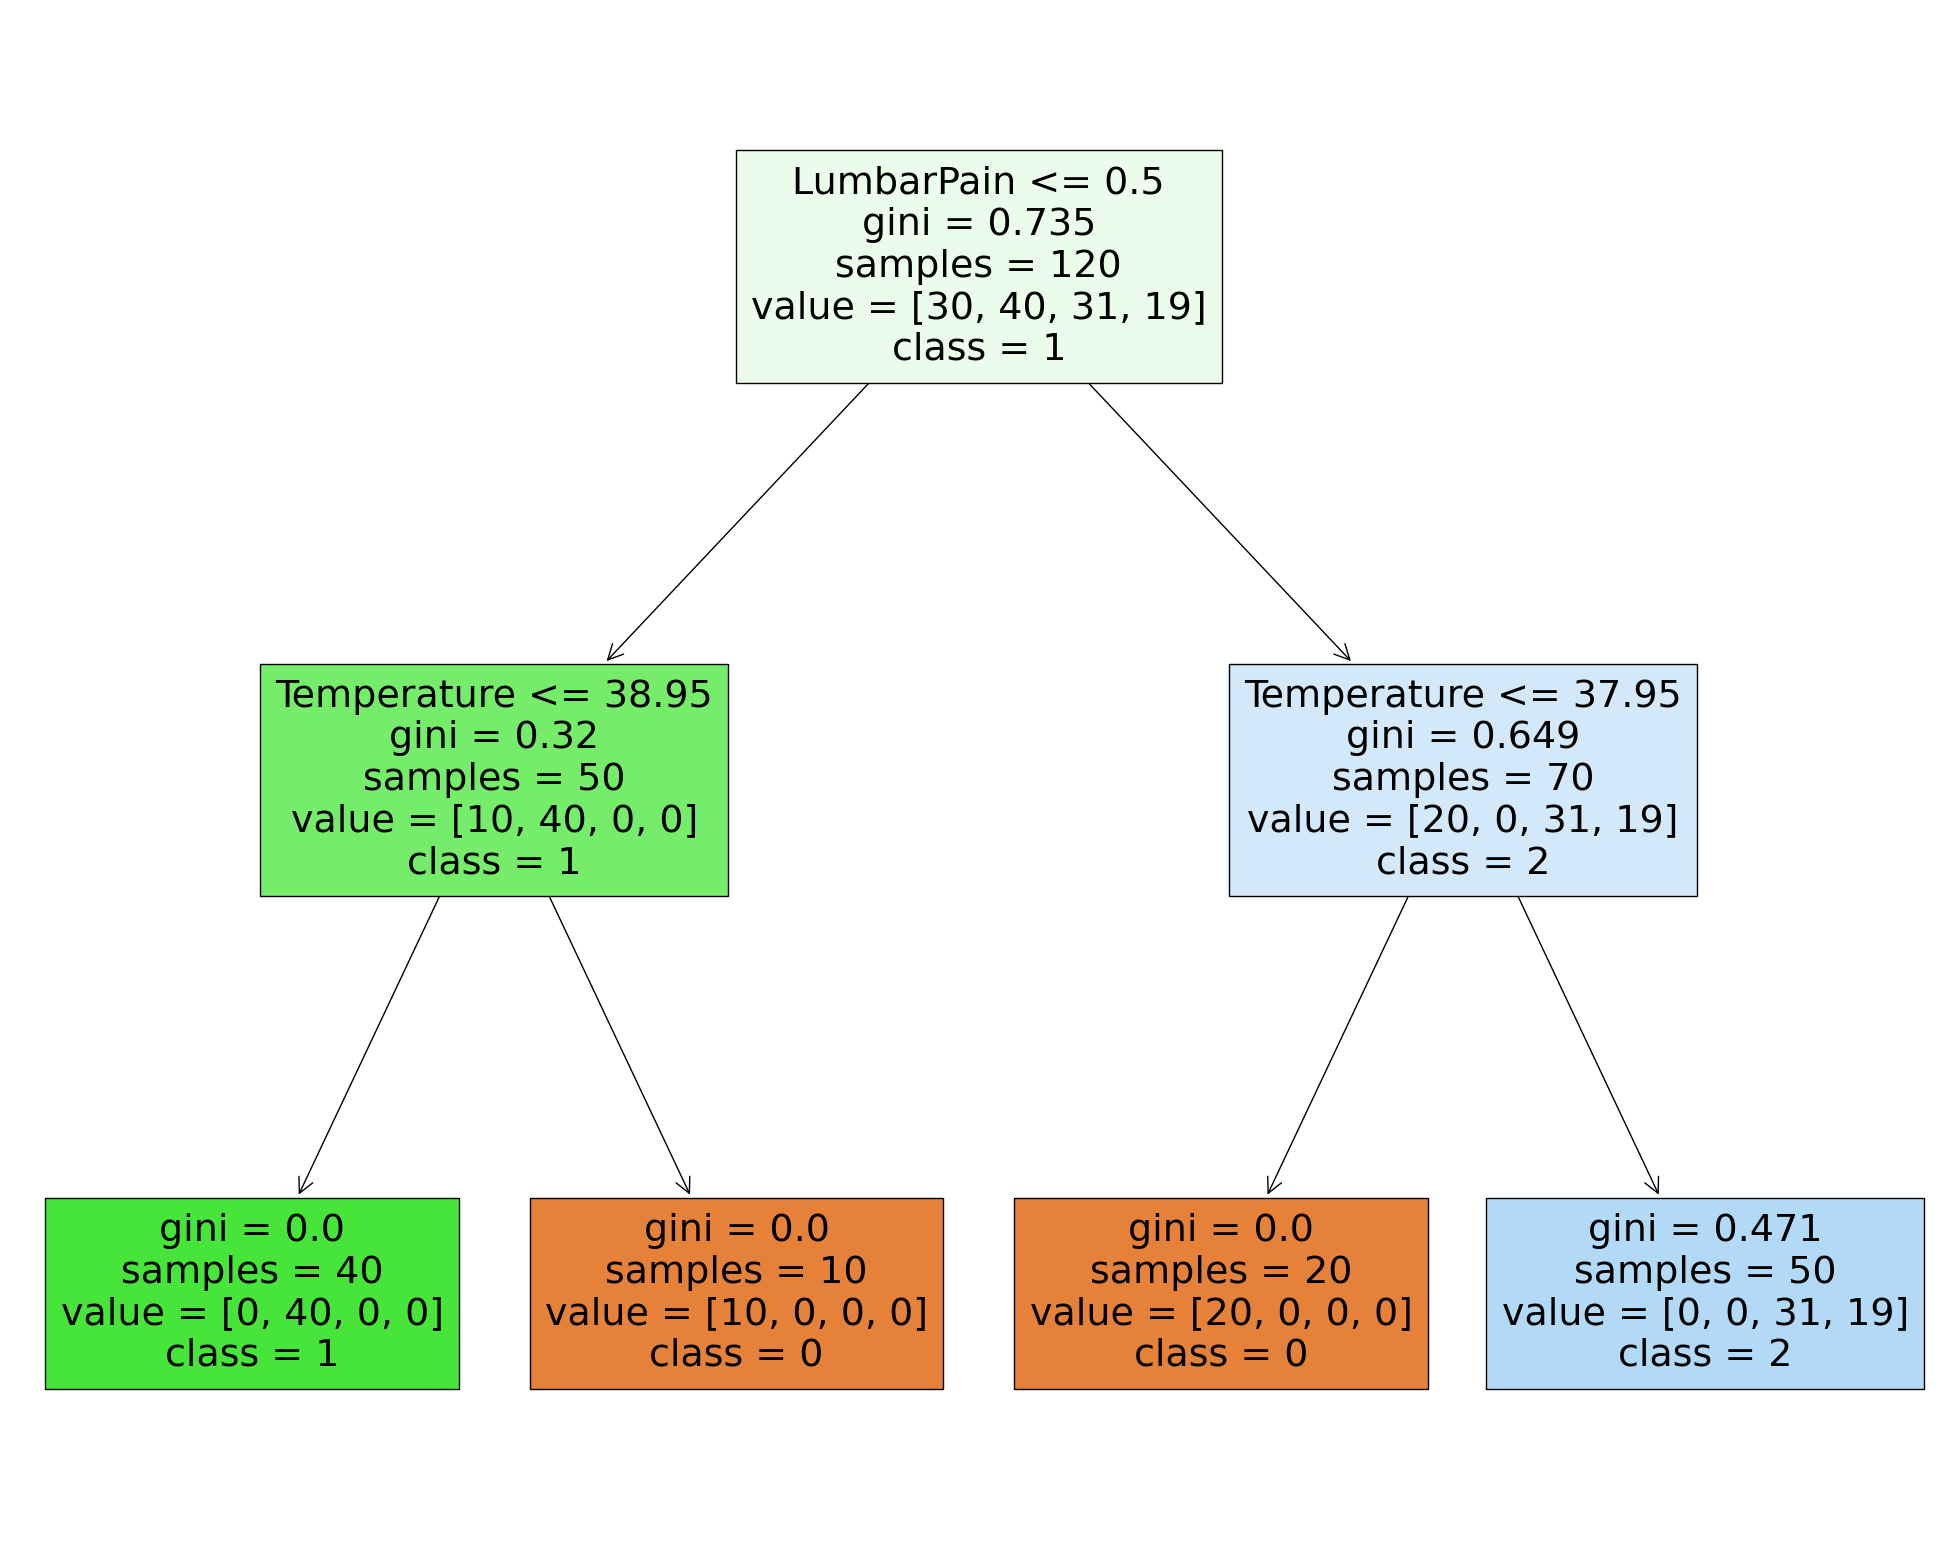

In [13]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clfs[1], 
                   feature_names=features,  
                   class_names=['0','1', '2', '3'],
                   filled=True)
print(tree.export_text(clfs[1]))
tree_to_pseudo(clfs[1], features)

Tree and rules for tree with highest accuracy

|--- feature_2 <= 0.50
|   |--- feature_0 <= 38.95
|   |   |--- class: 1
|   |--- feature_0 >  38.95
|   |   |--- class: 0
|--- feature_2 >  0.50
|   |--- feature_0 <= 37.95
|   |   |--- class: 0
|   |--- feature_0 >  37.95
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 2
|   |   |--- feature_1 >  0.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 3

 if ( LumbarPain <= 0.5 ) {
   if ( Temperature <= 38.95000076293945 ) {
     then return [[ 0. 40.  0.  0.]]
   } else {
     then return [[10.  0.  0.  0.]]
   }
 } else {
   if ( Temperature <= 37.95000076293945 ) {
     then return [[20.  0.  0.  0.]]
   } else {
     if ( Nausea <= 0.5 ) {
       then return [[ 0.  0. 21.  0.]]
     } else {
       if ( UrinePushing <= 0.5 ) {
         then return [[ 0.  0. 10.  0.]]
       } else {
         then return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }


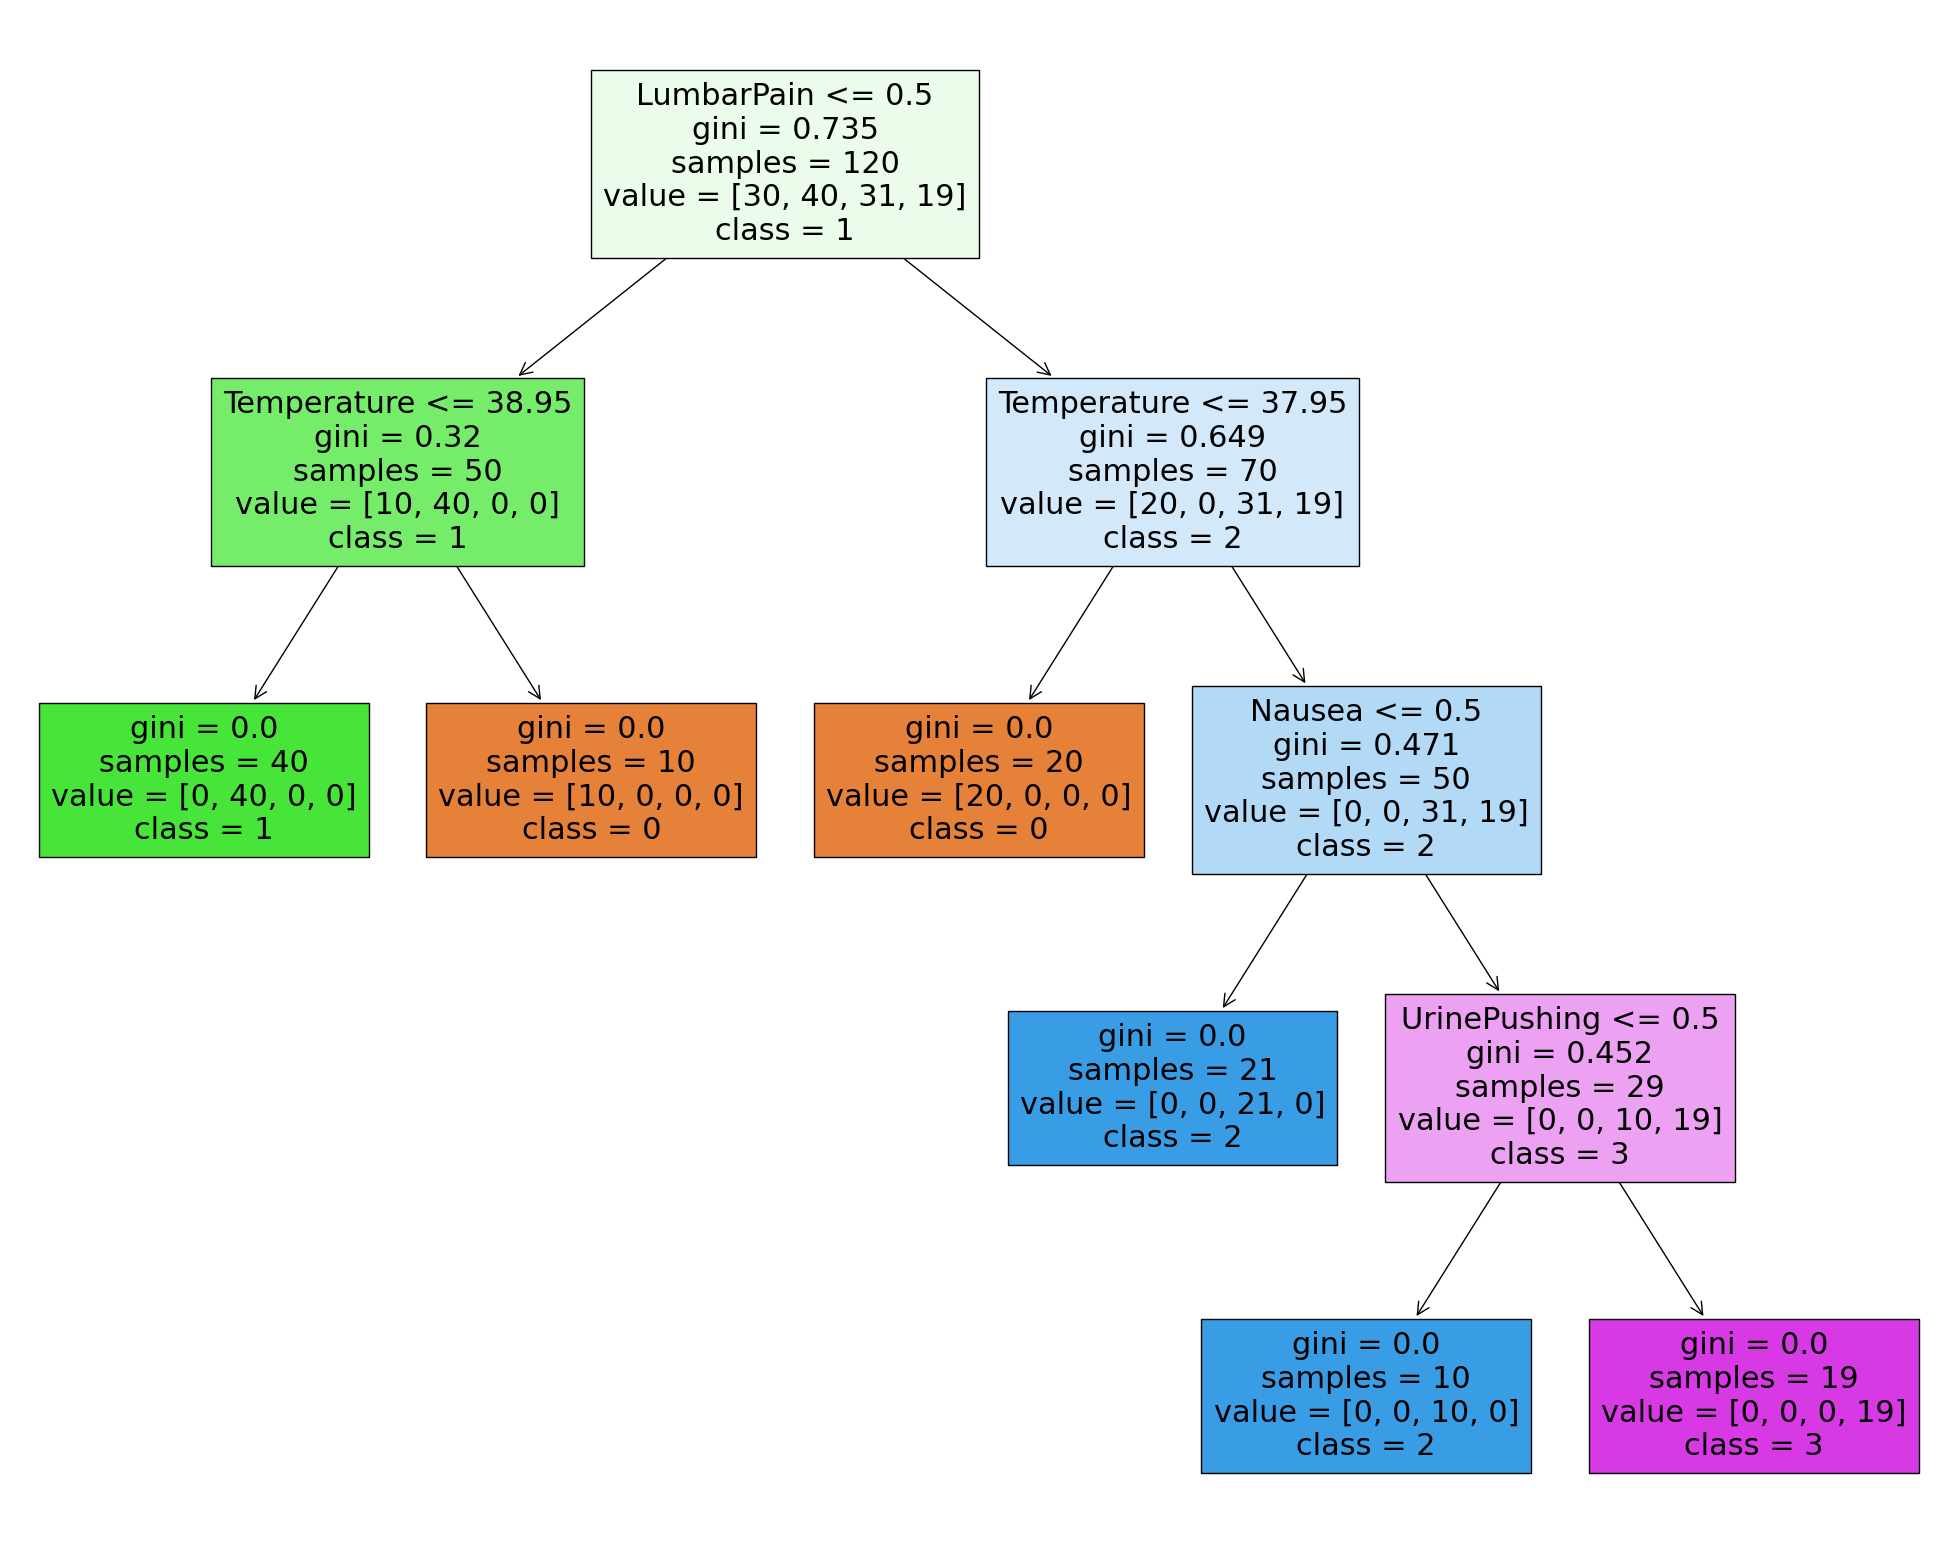

In [14]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clfs[0], 
                   feature_names=features,  
                   class_names=['0','1', '2', '3'],
                   filled=True)
print(tree.export_text(clfs[0]))
tree_to_pseudo(clfs[0], features)

## 2. The LASSO and Boosting for Regression

### Communities and Crime

### (a) Obtain Data

In [15]:
url = 'https://archive.ics.uci.edu/static/public/183/communities+and+crime.zip'
filename = '../data/communities_and_crime.zip'
urlretrieve(url, filename)

('../data/communities_and_crime.zip', <http.client.HTTPMessage at 0x1537ca350>)

In [16]:
headers = ['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']

In [17]:
zip = zipfile.ZipFile('../data/communities_and_crime.zip', 'r').extractall('../data/')

crime_df = pd.read_csv('../data/communities.data', sep=',',header=None, names = headers, na_values='?')
crime_df.shape
crime_df.replace({'?': None})

train, test = train_test_split(crime_df, train_size=1495, shuffle=False)

In [18]:
X_train = train.drop(columns=['ViolentCrimesPerPop'])
X_test = test.drop(columns=['ViolentCrimesPerPop'])
y_train = train['ViolentCrimesPerPop']
y_test = test['ViolentCrimesPerPop']

In [19]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(1495, 127)
(1495,)
(499,)
(499, 127)


### (b) Missing values

In [20]:
X_train = X_train.iloc[:, 5:]
X_test = X_test.iloc[:, 5:]

print(X_train.shape)
print(X_test.shape)

(1495, 122)
(499, 122)


In [21]:
# https://scikit-learn.org/stable/modules/impute.html
nan_val = np.nan
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer_model = imputer.fit(X_train)
X_train = pd.DataFrame(imputer_model.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer_model.transform(X_test), columns=X_test.columns)

In [22]:
crime_df_x_imputed = pd.concat([X_train, X_test])

### (c) Plot a correlation matrix

In [23]:
# https://builtin.com/data-science/correlation-matrix
corr_crime = crime_df_x_imputed.corr()
print(corr_crime)

                     population  householdsize  racepctblack  racePctWhite  \
population             1.000000      -0.046148      0.231178     -0.300845   
householdsize         -0.046148       1.000000     -0.067109     -0.235907   
racepctblack           0.231178      -0.067109      1.000000     -0.794389   
racePctWhite          -0.300845      -0.235907     -0.794389      1.000000   
racePctAsian           0.181603       0.201996     -0.106738     -0.270266   
...                         ...            ...           ...           ...   
PolicOperBudg          0.695558       0.034232      0.176062     -0.280737   
LemasPctPolicOnPatr   -0.115766      -0.015323     -0.193236      0.191206   
LemasGangUnitDeploy    0.063570      -0.027573      0.175185     -0.262822   
LemasPctOfficDrugUn    0.466352      -0.094368      0.260793     -0.276234   
PolicBudgPerPop        0.001794      -0.029348      0.113619     -0.097000   

                     racePctAsian  racePctHisp  agePct12t21  ag

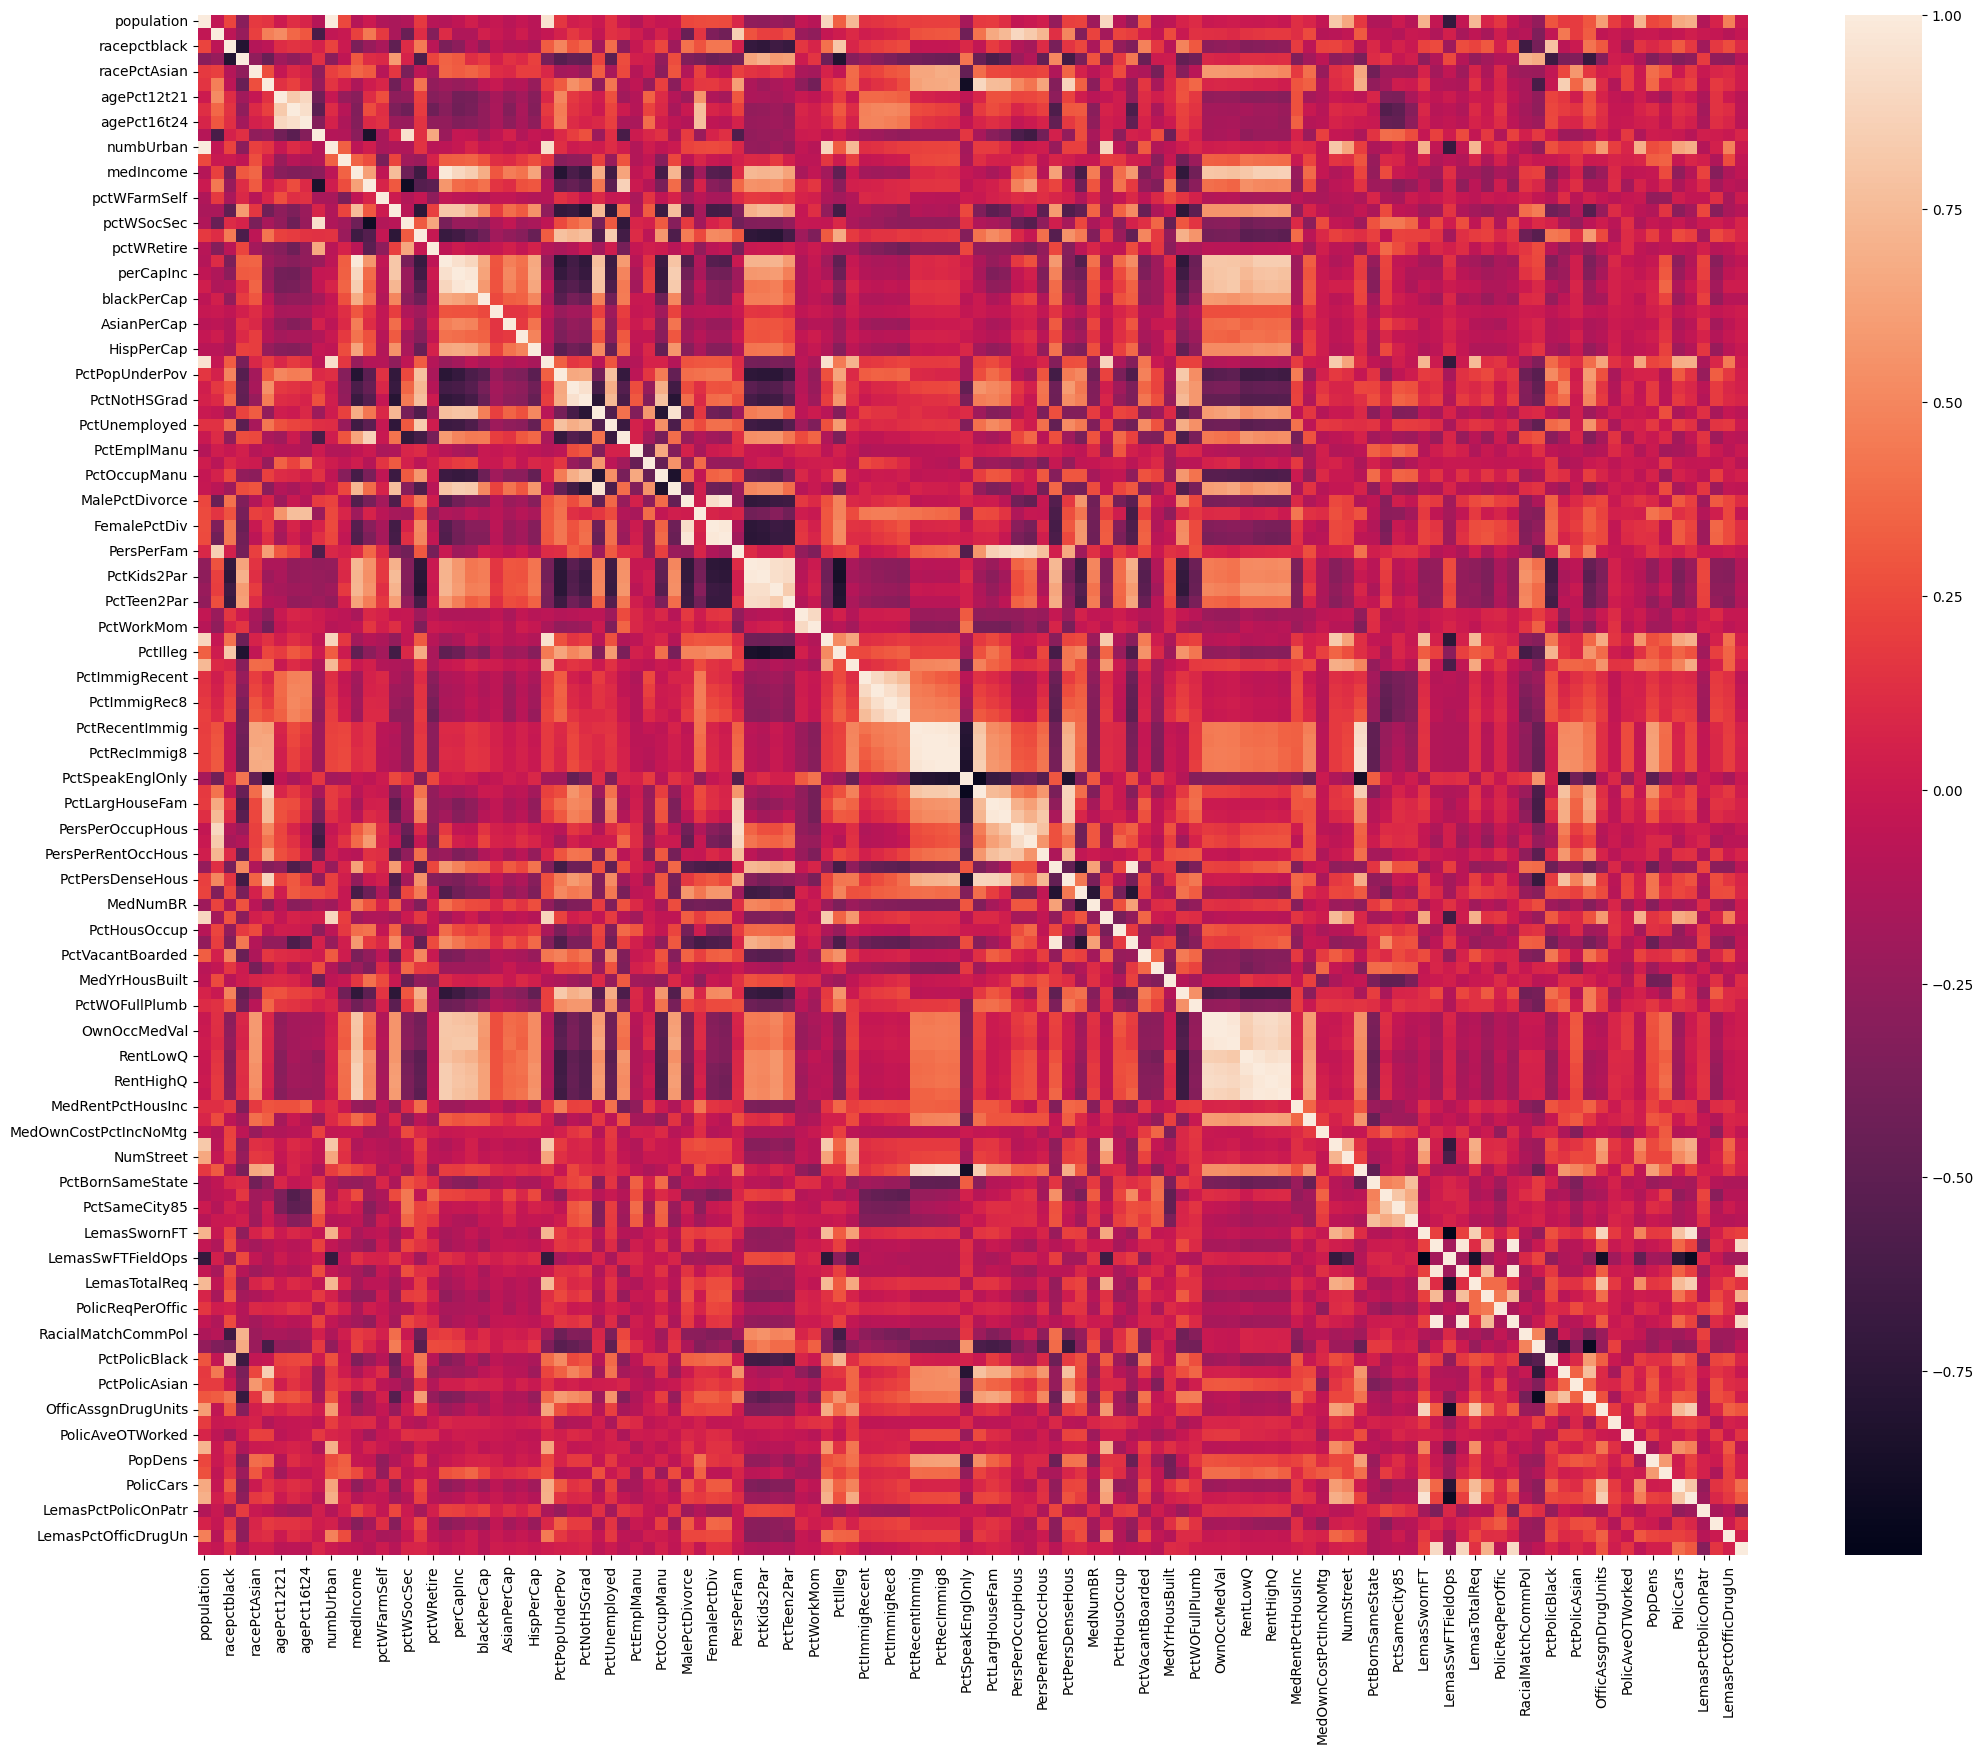

In [24]:
fig = plt.figure(figsize=(25,20))
_ = sns.heatmap(corr_crime)
# plt.show()

### (d) Calculate the Coefficient of Variation CV

In [25]:
#https://www.statology.org/coefficient-of-variation-in-python/
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100 
cv_crime = crime_df_x_imputed.apply(cv).to_dict()
print(cv_crime)

{'population': 220.3502536390983, 'householdsize': 35.32983018683121, 'racepctblack': 141.09203963756724, 'racePctWhite': 32.37815624993431, 'racePctAsian': 135.9162193822212, 'racePctHisp': 161.42777917106847, 'agePct12t21': 36.58398688397222, 'agePct12t29': 29.069288841904207, 'agePct16t24': 49.51605143654271, 'agePct65up': 42.34417088902623, 'numbUrban': 200.1743638195764, 'pctUrban': 63.88488712113604, 'medIncome': 57.97533935756006, 'pctWWage': 32.77100586060618, 'pctWFarmSelf': 70.00301156104892, 'pctWInvInc': 35.923994722340666, 'pctWSocSec': 36.85126303254, 'pctWPubAsst': 69.90305042033646, 'pctWRetire': 34.963908285758535, 'medFamInc': 52.77318853420786, 'perCapInc': 54.563342841914505, 'whitePerCap': 50.75521907214029, 'blackPerCap': 58.94690036844653, 'indianPerCap': 80.96850868666156, 'AsianPerCap': 60.61938508790927, 'OtherPerCap': 67.09644008403556, 'HispPerCap': 47.39597186074791, 'NumUnderPov': 230.4969714852216, 'PctPopUnderPov': 75.39801744357986, 'PctLess9thGrade': 6

In [26]:
# highest = np.array(list({k: v for k, v in sorted(cv_crime.items(), key=lambda item: item[1], reverse=True)}.items()))
highest = {k: v for k, v in sorted(cv_crime.items(), key=lambda item: item[1], reverse=True)} 
highest_keys = list(highest.keys())
selected_features = []
for i in range(0,11):
    selected_features.append(highest_keys[i])

print(selected_features)

['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'PctPolicAsian', 'numbUrban', 'HousVacant', 'LemasSwornFT']


### (e) Scatter plots and box plots for highest CV features

<Figure size 2500x2000 with 0 Axes>

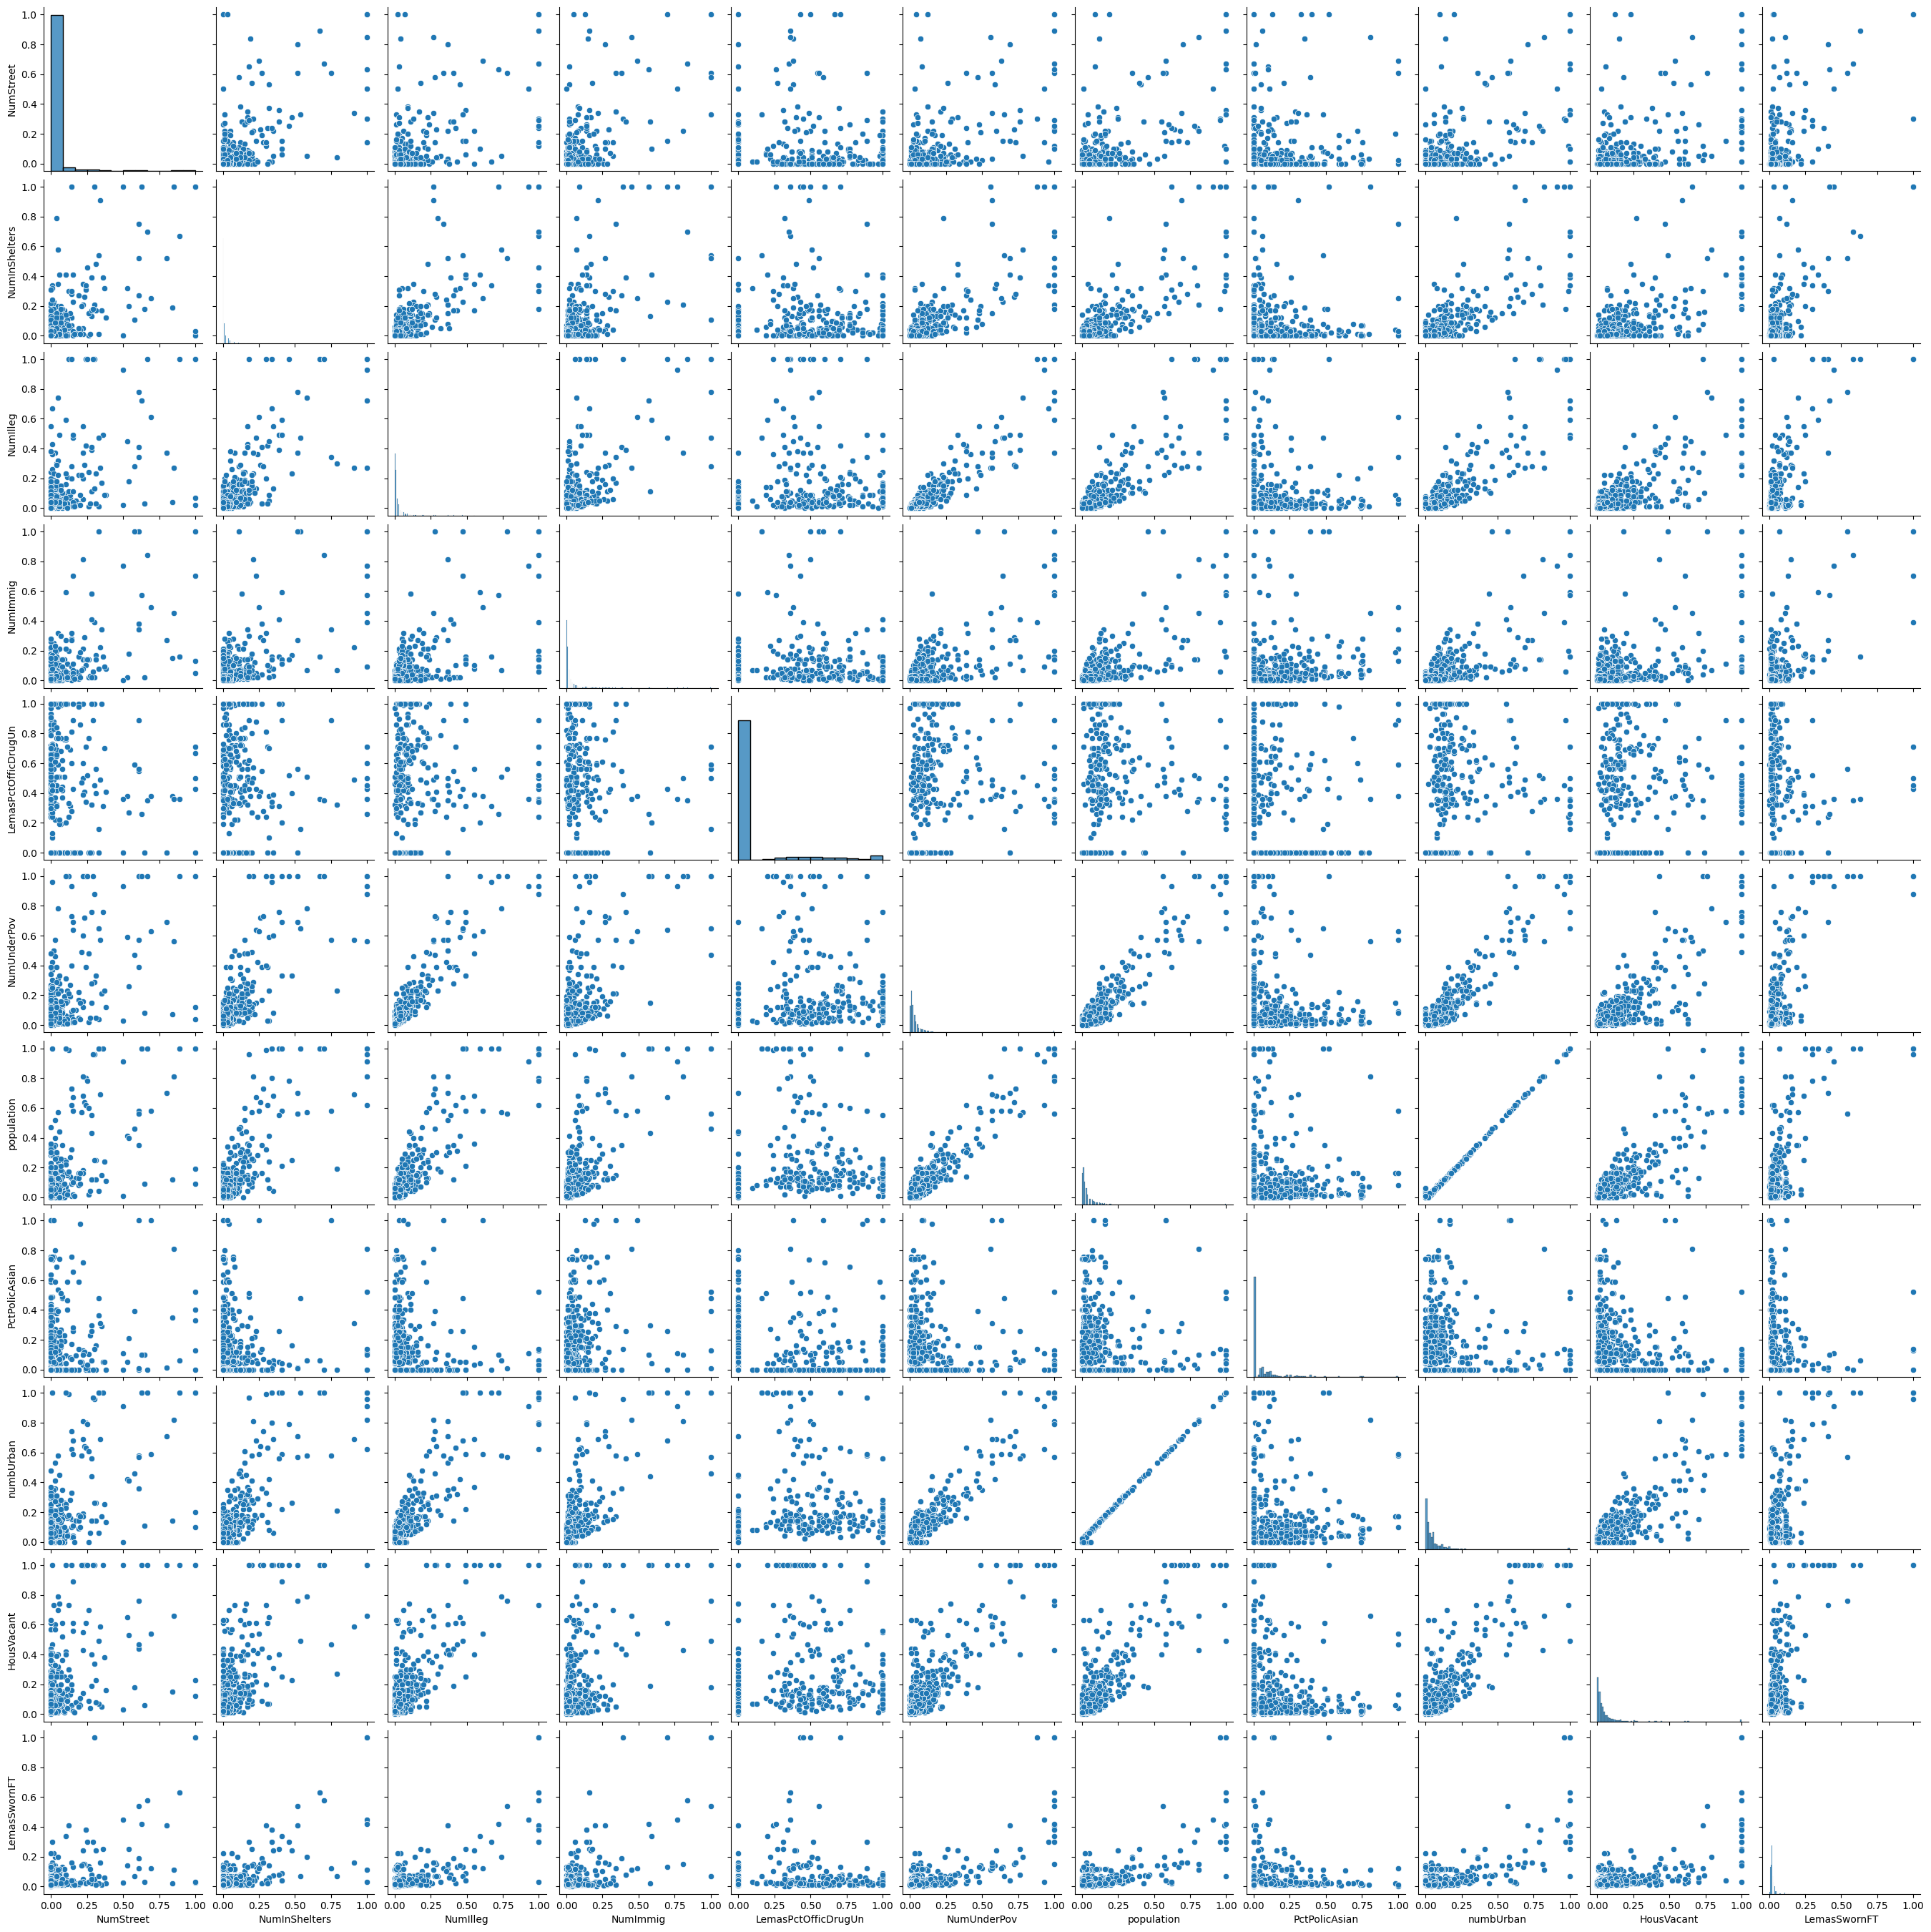

In [27]:
fig = plt.figure(figsize=(25,20))
_ = sns.pairplot(data=X_train[selected_features])

#### Observations from Scatter plots
* We can observe that NumbUrban(number of people living in areas classified as urban) and Population(population for community) are positively correlated  
* Values for LemasSwornFt(number of sworn full time police officers) is skewed between 0 and 0.1 as seen from scatter plot and boxplot
* LemasPctOfficDrugUn(percent of officers assigned to drug units) and NumStreet(number of homeless people counted in the street) have most values as 0 as observed from the scatter plot and boxplot

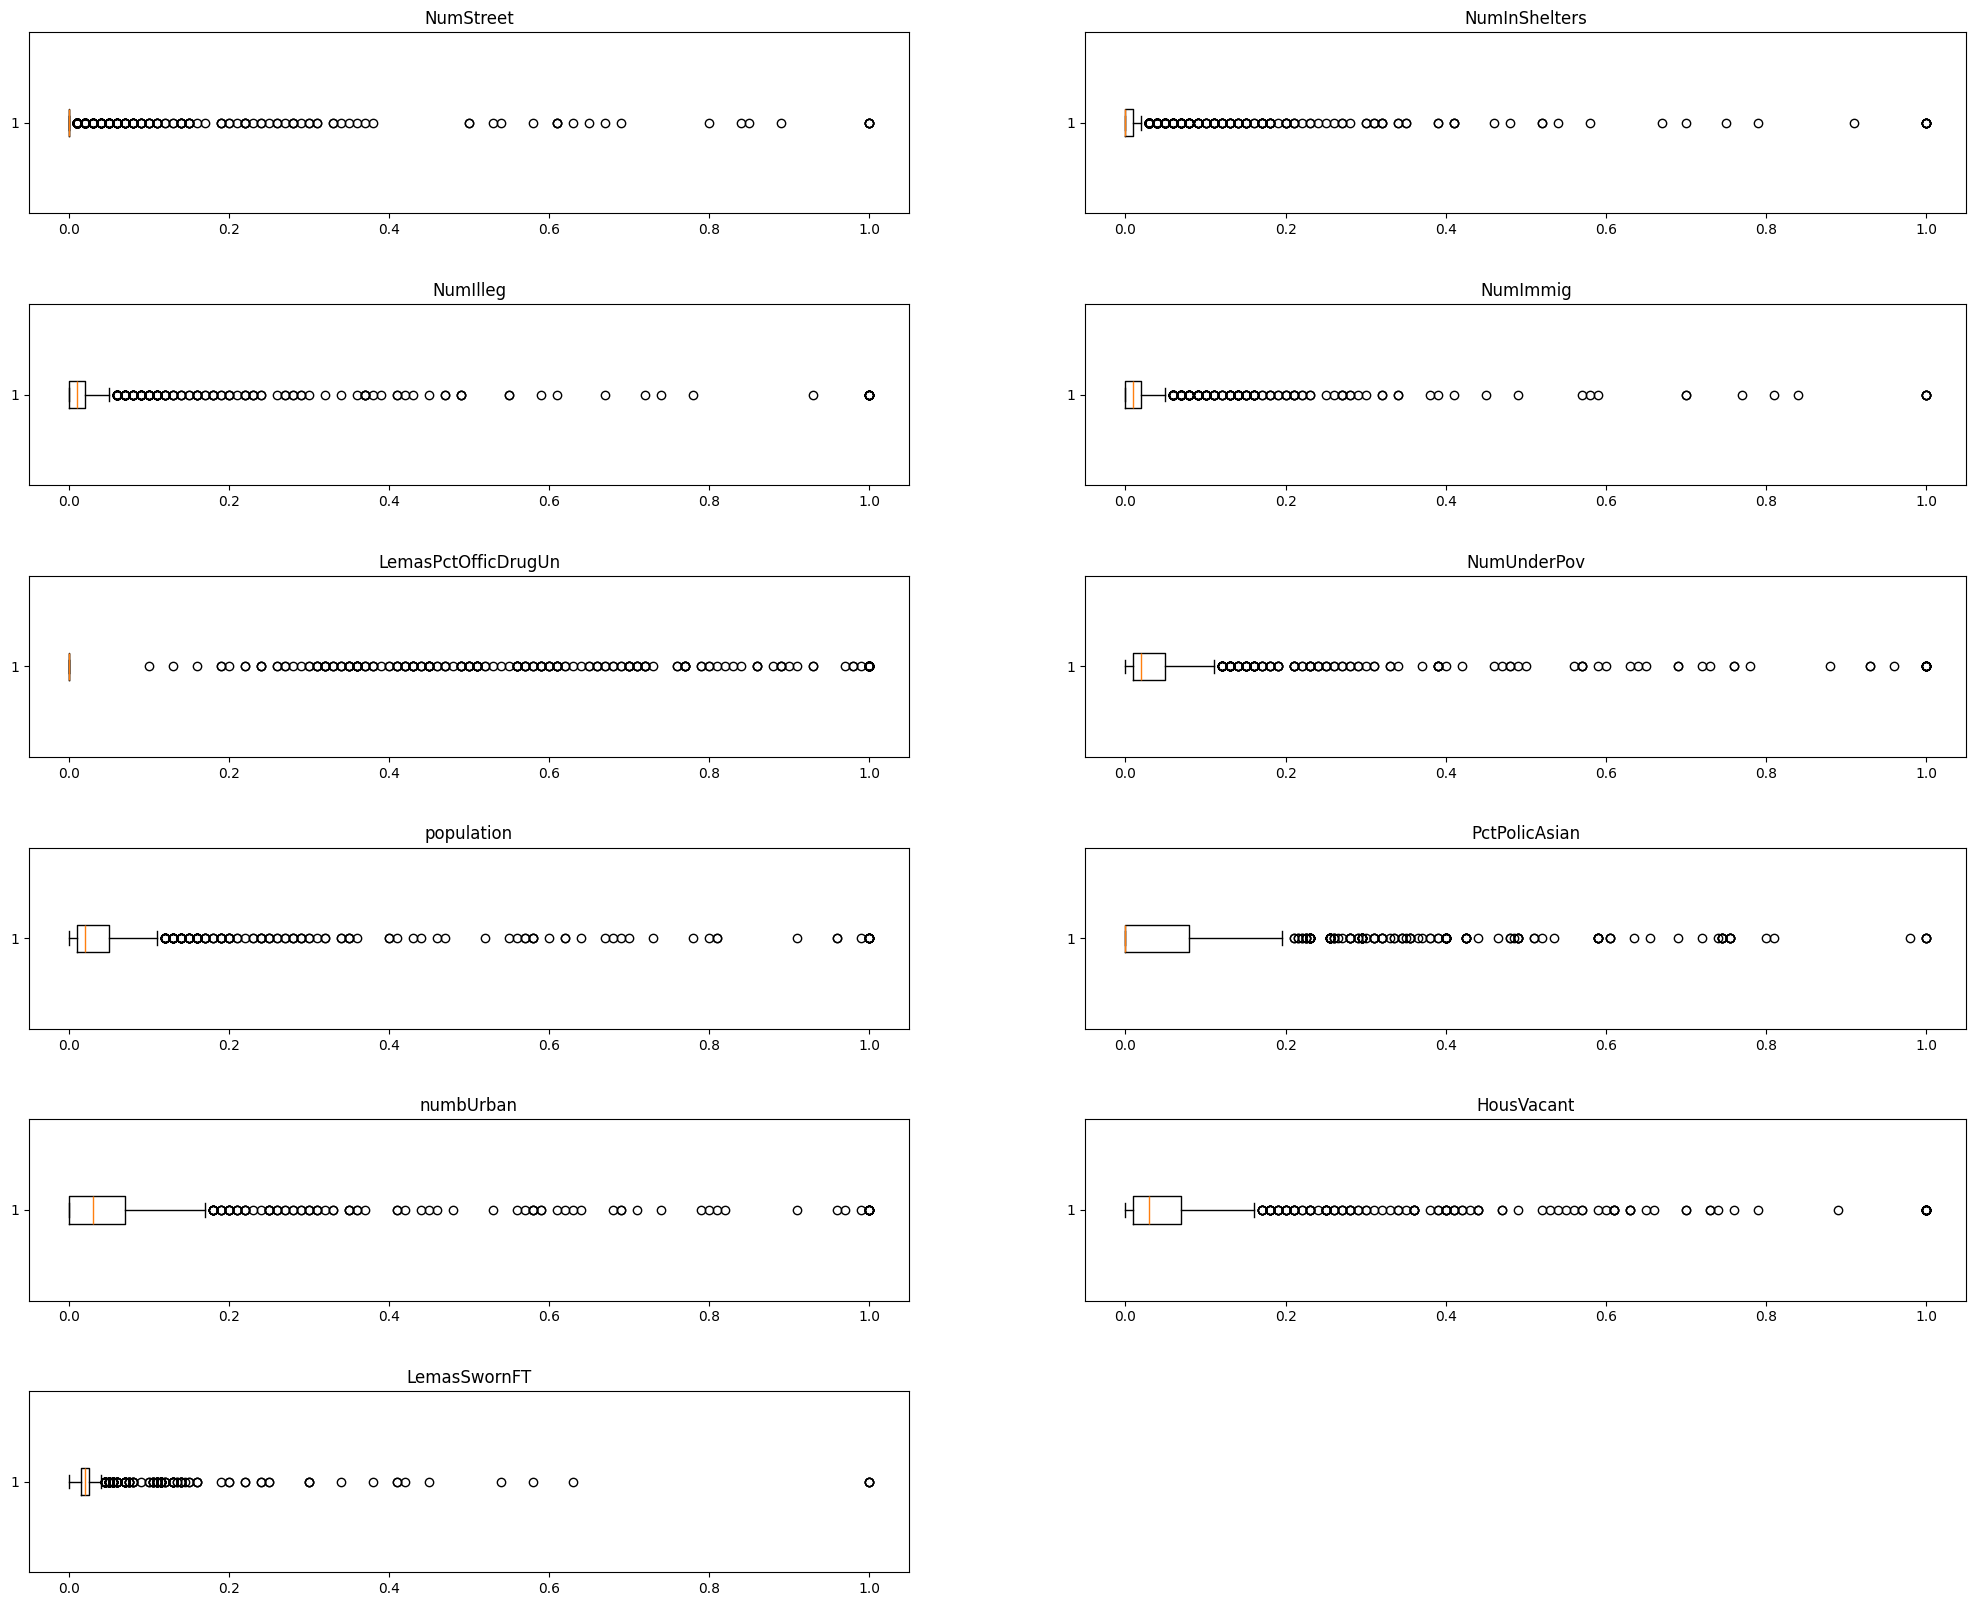

In [28]:
fig = plt.figure(figsize=(25,20))
for i, feature in enumerate(selected_features):
    plt.subplot(6,2,i+1)
    plt.title(feature)
    plt.boxplot(X_train[feature], notch=None, vert=False, patch_artist=None, widths=None)
plt.subplots_adjust(hspace=0.5)

### (f) Fit a linear model

In [29]:
X_train_constant = sm.add_constant(X_train)
X_test_constant = sm.add_constant(X_test)

linear_model = sm.OLS(y_train,X_train_constant)
linear_model = linear_model.fit()

linear_y_pred = linear_model.predict(X_test_constant)

print('Test Error for Linear Model: ', mean_squared_error(linear_y_pred, y_test))
print(linear_model.summary())

Test Error for Linear Model:  0.017643253807660093
                             OLS Regression Results                            
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.720
Model:                             OLS   Adj. R-squared:                  0.695
Method:                  Least Squares   F-statistic:                     29.14
Date:                 Fri, 27 Oct 2023   Prob (F-statistic):          1.28e-299
Time:                         23:02:51   Log-Likelihood:                 978.02
No. Observations:                 1495   AIC:                            -1712.
Df Residuals:                     1373   BIC:                            -1064.
Df Model:                          121                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

### (g) Fit a ridge regression model

In [30]:
param_grid = {
    'alpha': np.arange(1e-3, 10, 1e-2)
}

ridge_model = GridSearchCV(Ridge(), param_grid, cv=KFold(n_splits=7, random_state=1, shuffle=True), n_jobs=-1, scoring='neg_mean_squared_error')
ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

In [31]:
print('Test Error for Ridge model: ', mean_squared_error(ridge_y_pred, y_test))
print('Alpha (λ) for Ridge Model: ', ridge_model.best_params_)

Test Error for Ridge model:  0.017190306337062335
Alpha (λ) for Ridge Model:  {'alpha': 3.0709999999999993}


### (h) Fit a LASSO model

In [32]:
lasso_alphas = [10**i for i in range(-10, 10)]
lasso_model = LassoCV(alphas=lasso_alphas, cv=5, max_iter=1000000)
lasso_model.fit(X_train, y_train.values.ravel())
lasso_y_pred = lasso_model.predict(X_test)
print('Test Error Lasso Model: ', mean_squared_error(lasso_y_pred, y_test))
print('Alpha (λ) for Lasso Model: ', lasso_model.alpha_)

Test Error Lasso Model:  0.017459062210288954
Alpha (λ) for Lasso Model:  0.0001


In [33]:
lasso_features = []

for i, coef in enumerate(lasso_model.coef_):
    if(coef != 0):
        lasso_features.append([X_train.columns[i], coef])

print(tabulate(lasso_features, headers=['Feature', 'Coefficient']))

Feature                  Coefficient
---------------------  -------------
population              -0.00426226
racepctblack             0.232668
racePctAsian            -0.0643922
racePctHisp              0.0337611
agePct12t21              0.0676291
agePct12t29             -0.276369
agePct65up               0.0261957
pctUrban                 0.0415847
pctWWage                -0.0618623
pctWFarmSelf             0.0280069
pctWInvInc              -0.108689
pctWSocSec               0.0550837
pctWPubAsst              0.0558897
pctWRetire              -0.114405
whitePerCap             -0.0352211
blackPerCap             -0.0117521
indianPerCap            -0.0280756
AsianPerCap              0.0302834
OtherPerCap              0.0221258
HispPerCap               0.0171864
PctPopUnderPov          -0.0908661
PctLess9thGrade         -0.0389893
PctBSorMore              0.00801847
PctEmploy                0.147006
PctEmplManu             -0.0120012
PctOccupMgmtProf         0.00557131
MalePctDivorce    

In [34]:
scaler = StandardScaler().fit(X_train)
std_train_x = scaler.transform(X_train)
std_test_x = scaler.transform(X_test)
std_lasso_model = LassoCV(alphas=lasso_alphas, cv=5, max_iter=1000000)
std_lasso_model.fit(std_train_x, y_train.values.ravel())
std_lasso_y_pred = std_lasso_model.predict(std_test_x)
print('Test Error Standardized Lasso Model: ', mean_squared_error(std_lasso_y_pred, y_test))
print('Alpha for Standardized Lasso Model: ', std_lasso_model.alpha_)

Test Error Standardized Lasso Model:  0.017512011978640975
Alpha for Standardized Lasso Model:  0.001


In [35]:
std_lasso_features = []

for i, coef in enumerate(std_lasso_model.coef_):
    if(coef != 0):
        std_lasso_features.append([X_train.columns[i], coef])

print(tabulate(std_lasso_features, headers=['Feature', 'Coefficient']))

Feature                  Coefficient
---------------------  -------------
racepctblack             0.0546512
racePctAsian            -0.0101283
racePctHisp              0.00243957
agePct12t21              0.00391416
agePct12t29             -0.0276616
pctUrban                 0.0165841
pctWWage                -0.00315384
pctWFarmSelf             0.00258865
pctWInvInc              -0.0164573
pctWSocSec               0.00687945
pctWPubAsst              0.00616874
pctWRetire              -0.0154398
blackPerCap             -0.00129966
indianPerCap            -0.00416558
AsianPerCap              0.00543303
OtherPerCap              0.00336814
HispPerCap               0.00143524
PctPopUnderPov          -0.00931328
PctLess9thGrade         -0.00109294
PctEmploy                0.0131612
PctEmplManu             -0.0011919
MalePctDivorce           0.011501
MalePctNevMarr           0.0155217
FemalePctDiv            -0.0028515
PctKids2Par             -0.0422309
PctYoungKids2Par        -0.00809842
Pct

In [36]:
print('Test Error Lasso Model: ', mean_squared_error(lasso_y_pred, y_test))
print('Number of features selected by Lasso Model: ', len(lasso_features))
print('Test Error Standardized Lasso Model: ', mean_squared_error(std_lasso_y_pred, y_test))
print('Number of features selected by Standardised Lasso Model: ', len(std_lasso_features))

Test Error Lasso Model:  0.017459062210288954
Number of features selected by Lasso Model:  78
Test Error Standardized Lasso Model:  0.017512011978640975
Number of features selected by Standardised Lasso Model:  69


The test error for Lasso on unstandardized and standardized features is nearly the same, differing by 0.00006

### (i) Fit a PCR model

In [37]:
# https://stackoverflow.com/questions/64539907/scoring-increasing-with-number-of-components-using-pca
# https://www.pls-regression.com/python/3-cross-validation/


pcr_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('linear', LinearRegression())])

param_grid = {
    'pca__n_components': np.arange(1, len(X_train.columns), 1)
}

pcr_model = GridSearchCV(pcr_pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
pcr_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linear', LinearRegression())]),
             n_jobs=-1,
             param_grid={'pca__n_components': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121])},
             scoring='neg_mean_squared_error')

In [38]:
pcr_y_pred = pcr_model.predict(X_test)
print('Test Error for PCR Model: ', mean_squared_error(pcr_y_pred, y_test))
print('Number of components for PCR Model: ', pcr_model.best_params_)    

Test Error for PCR Model:  0.017961866756705188
Number of components for PCR Model:  {'pca__n_components': 94}


### (j) Fit a boosting tree

In [39]:
param_grid = {
    'alpha': np.arange(1e-1, 10, 1e-1)
}
xgb = XGBRegressor()
xgb_model = GridSearchCV(xgb, param_grid, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_model.fit(X_train, y_train)

xgb_y_pred = xgb_model.predict(X_test)

In [40]:
print('Test Error for XGBoost Tree: ', mean_squared_error(xgb_y_pred, y_test))
print('Alpha (λ) for XGBoost Tree : ', xgb_model.best_params_)

Test Error for XGBoost Tree:  0.01911338736523387
Alpha (λ) for XGBoost Tree :  {'alpha': 1.2000000000000002}
